# 电影用户评分数据挖掘
MovieLens 100k数据集包含表示多个用户对多部电影的10万次评级数据;  
## 数据结构展示
**数据展示**
* *u.user*
> user.id、age、gender、occupation、ZIP code
* *u.item*
> movie.id、title、release date、IMDB link、电影分类相关属性
* *u.data*
> user.id、movie.id、rating

In [1]:
%%bash
head -5 ~/data/ml-100k/u.user
echo "------------------------------"
echo "------------------------------"
head -5 ~/data/ml-100k/u.item
echo "------------------------------"
echo "------------------------------"
head -5 ~/data/ml-100k/u.data

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067
4|24|M|technician|43537
5|33|F|other|15213
------------------------------
------------------------------
1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
------------------------------
------------------------------
196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596


##  用户数据

In [2]:
%%bash
hadoop fs -ls -h /user/yanbin/data/ml-100k

Found 23 items
-rw-r--r--   1 yanbin supergroup      6.6 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/README
-rw-r--r--   1 yanbin supergroup        716 2017-05-18 16:51 /user/yanbin/data/ml-100k/allbut.pl
-rw-r--r--   1 yanbin supergroup        643 2017-05-18 16:51 /user/yanbin/data/ml-100k/mku.sh
-rw-r--r--   1 yanbin supergroup      1.9 M 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.data
-rw-r--r--   1 yanbin supergroup        202 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.genre
-rw-r--r--   1 yanbin supergroup         36 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.info
-rw-r--r--   1 yanbin supergroup    230.8 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.item
-rw-r--r--   1 yanbin supergroup        193 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.occupation
-rw-r--r--   1 yanbin supergroup     22.1 K 2017-05-18 16:51 /user/yanbin/data/ml-100k/u.user
-rw-r--r--   1 yanbin supergroup      1.5 M 2017-05-18 16:51 /user/yanbin/data/ml-100k/u1.base
-rw-r--r--   1 yanbin supergroup  

In [3]:
from pyspark import SparkContext,SparkConf
from operator import add
from pyspark.sql import SparkSession
from pyspark.sql import HiveContext
from pandas import *
import matplotlib.pyplot as plt
#创建SparkSession无法连接Hive
# spark = SparkSession \
#     .builder \
#     .appName("pyspark") \
#     .config("spark.some.config.option", "some-value") \
#     .getOrCreate()
# sc=spark.sparkContext
sc=SparkContext()
spark=HiveContext(sc)

In [4]:
userPath="data/ml-100k/u.user"
rawdata=sc.textFile(userPath)
rawdata.first()

u'1|24|M|technician|85711'

In [5]:
spark.sql("show databases").show()

+------------+
|databaseName|
+------------+
|     default|
|      yanbin|
+------------+



In [6]:
import re
pattern = re.compile(r"[^\d+]")
data=rawdata.map(lambda x:x.split("|"))
def f(x):
    print x
data.filter(lambda x:pattern.match(x[4]))
data=data.map(lambda x:(int(x[0]),int(x[1]),x[2],x[3],str(x[4])))
print data.first(),data.count()

(1, 24, u'M', u'technician', '85711') 943


In [7]:
from pyspark.sql import Row
User = Row('id','age','gender','occupation','zip_code')
user = data.map(lambda r:User(*r))
user.first()
userDf = spark.createDataFrame(user)
userDf.limit(5).show()
userDf.dtypes

+---+---+------+----------+--------+
| id|age|gender|occupation|zip_code|
+---+---+------+----------+--------+
|  1| 24|     M|technician|   85711|
|  2| 53|     F|     other|   94043|
|  3| 23|     M|    writer|   32067|
|  4| 24|     M|technician|   43537|
|  5| 33|     F|     other|   15213|
+---+---+------+----------+--------+



[('id', 'bigint'),
 ('age', 'bigint'),
 ('gender', 'string'),
 ('occupation', 'string'),
 ('zip_code', 'string')]

In [8]:
from pyspark.sql.functions import minute,min
userDf.describe(['age']).show()
userDf.printSchema()
# userDf.select(userDf.id.cast("int")).first()
# userDf.select(min('age').alias('min')).first()

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              943|
|   mean|34.05196182396607|
| stddev|12.19273973305903|
|    min|                7|
|    max|               73|
+-------+-----------------+

root
 |-- id: long (nullable = true)
 |-- age: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zip_code: string (nullable = true)



In [9]:
userDf.select(userDf.age.isNull().alias("ageIsNull"),userDf.id.isNull().alias("idIsNull")).where("ageIsNull=true").count()

0

In [10]:
from pyspark.sql.types import *
struct = StructType()
sf1=StructField("id",IntegerType(),True)
sf2=StructField("age",StringType(),True)
sf3=StructField("gender",StringType(),True)
sf4=StructField("occupation",StringType(),True)
sf5=StructField("zip_code",StringType(),True)
struct.add(sf1).add(sf2).add(sf3).add(sf4).add(sf5)
# struct
#RDD转换成dataFrame时，类型不对应会报错。但转成StringType不会;
nf=spark.createDataFrame(data,struct)
#以Seq类型定义schema名称，类型依RDD相应转换
#spark.createDataFrame(data,("id","age","gender","occupation","zip_code")).dtypes

In [11]:
userDf.sort(userDf.age.desc())
from pyspark.sql.functions import *
userDf.sort(asc("age")).show()

+---+---+------+-------------+--------+
| id|age|gender|   occupation|zip_code|
+---+---+------+-------------+--------+
| 30|  7|     M|      student|   55436|
|471| 10|     M|      student|   77459|
|289| 11|     M|         none|   94619|
|674| 13|     F|      student|   55337|
|880| 13|     M|      student|   83702|
|609| 13|     F|      student|   55106|
|142| 13|     M|        other|   48118|
|628| 13|     M|         none|   94306|
|813| 14|     F|      student|   02136|
|206| 14|     F|      student|   53115|
|887| 14|     F|      student|   27249|
|618| 15|     F|      student|   44212|
|281| 15|     F|      student|   06059|
|179| 15|     M|entertainment|   20755|
|461| 15|     M|      student|   98102|
|101| 15|     M|      student|   05146|
|849| 15|     F|      student|   25652|
|434| 16|     F|      student|   49705|
|550| 16|     F|      student|   95453|
|451| 16|     M|      student|   48446|
+---+---+------+-------------+--------+
only showing top 20 rows



In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
nf=nf.select(nf.id,nf.age.cast(IntegerType()),nf.gender,nf.occupation,nf.zip_code)
nf.registerTempTable("user")
sqlString="with t1 as (select count(distinct(age)) as ages from user),\
           t2 as (select count(distinct(gender)) as genders from user), \
           t3 as (select count(distinct(occupation)) as occupations from user) \
            select * from t1 cross join t2 cross join t3"
spark.sql(sqlString).show()

+----+-------+-----------+
|ages|genders|occupations|
+----+-------+-----------+
|  61|      2|         21|
+----+-------+-----------+



## 按年龄区间计算用户分布

+---+------+------+-------------+--------+
| id|newage|gender|   occupation|zip_code|
+---+------+------+-------------+--------+
|  1|     1|     M|   technician|   85711|
|  2|     4|     F|        other|   94043|
|  3|     1|     M|       writer|   32067|
|  4|     1|     M|   technician|   43537|
|  5|     2|     F|        other|   15213|
|  6|     3|     M|    executive|   98101|
|  7|     5|     M|administrator|   91344|
|  8|     3|     M|administrator|   05201|
|  9|     2|     M|      student|   01002|
| 10|     4|     M|       lawyer|   90703|
| 11|     3|     F|        other|   30329|
| 12|     2|     F|        other|   06405|
| 13|     4|     M|     educator|   29206|
| 14|     4|     M|    scientist|   55106|
| 15|     4|     F|     educator|   97301|
| 16|     1|     M|entertainment|   10309|
| 17|     2|     M|   programmer|   06355|
| 18|     3|     F|        other|   37212|
| 19|     3|     M|    librarian|   02138|
| 20|     3|     F|    homemaker|   95660|
+---+------

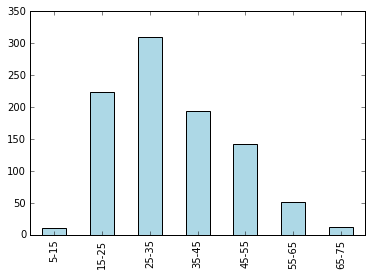

In [13]:
condition="case \
when  5<=age and age<15 then 0 \
when 10<=age and age<25 then 1 \
when age>=25 and age<35 then 2 \
when age>=35 and age<45 then 3 \
when age>=45 and age<55 then 4 \
when age>=55 and age<65 then 5 \
when age>=65 and age<75 then 6 \
when age>=75 and age<85 then 7 \
end "
gdf=spark.sql("select id,"+condition+" as newage,gender,occupation,zip_code from user")
gdf.show()
ageDf=gdf.groupBy(gdf.newage).count().sort(asc("newage"))
# cnt=ageDf.groupBy().sum('count').collect()[0][0]
# ageDf=ageDf.join(ageDf.selectExpr(("count/"+str(cnt)+" as frec")),"frec",'outer')
ageDf.show()
ageDf=ageDf.toPandas()
ageDf.index=["5-15","15-25","25-35","35-45","45-55","55-65","65-75"]
ageDf=ageDf.loc[:,'count']
ageDf.plot(kind='bar',color='lightblue')
# plt.hist(list(ageDf['count']),bins=20,color='lightblue',normed=True)
# nf.select(nf.age).toPandas().hist(bins=10,color='lightblue',normed=True)
# fig=plt.gcf()

# gdf.groupBy(username.).max("id").show()

## 用户职业分布

In [14]:
gdf.createTempView("newUser")

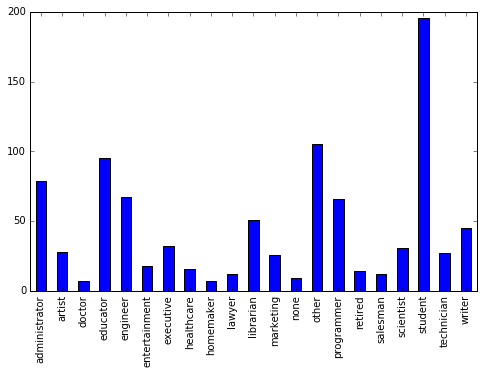

In [15]:
occDf=spark.sql("select occupation ,count(*) as count from newUser group by occupation").sort("occupation")
occDf.head()
occDf=occDf.toPandas()
occDf.index=list(occDf.ix[:,0])
occDf['count'].plot(kind='bar')
fig=plt.gcf()
fig.set_size_inches(8,5)

In [16]:
%time
#gdf.groupBy("newage","occupation").count().sort('newage').show()
import numpy as np
from pandas import DataFrame
# df=DataFrame(np.zeros(21,7),index=list(occDf['occupation']),columns=np.arange(8))
# spark.sql("show databases").show()
# spark.sql("create table test1 as (select newage,occupation ,count(*) as cnt from newUser group by occupation,newage)").show()
sqlString="with t as \
(select newage,occupation ,count(*) as count from newUser group by occupation,newage) \
select occupation, \
max(case newage when 0 then cnt else 0 end ) as 5_15,\
max(case newage when 1 then cnt else 0 end) as 15_25,\
max(case newage when 2 then cnt else 0 end) as 25_35,\
max(case newage when 3 then cnt else 0 end) as 35_45,\
max(case newage when 4 then cnt else 0 end) as 45_55,\
max(case newage when 5 then cnt else 0 end) as 55_65,\
max(case newage when 6 then cnt else 0 end) as 65_75 \
from test1 group by occupation\
"
uAndC=spark.sql(sqlString).sort(asc('occupation'))
uAndC=uAndC.toPandas()
uAndC.index=list(uAndC.ix[:,0])
uAndC.ix[:,1:]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


,5_15,15_25,25_35,35_45,45_55,55_65,65_75
administrator,0,6,26,20,22,4,1
artist,0,6,13,6,3,0,0
doctor,0,0,2,1,3,1,0
educator,0,1,29,23,29,13,0
engineer,0,12,20,22,7,5,1
entertainment,0,9,5,2,2,0,0
executive,0,1,11,10,8,1,1
healthcare,0,1,4,3,7,1,0
homemaker,0,2,2,2,1,0,0
lawyer,0,1,5,2,4,0,0


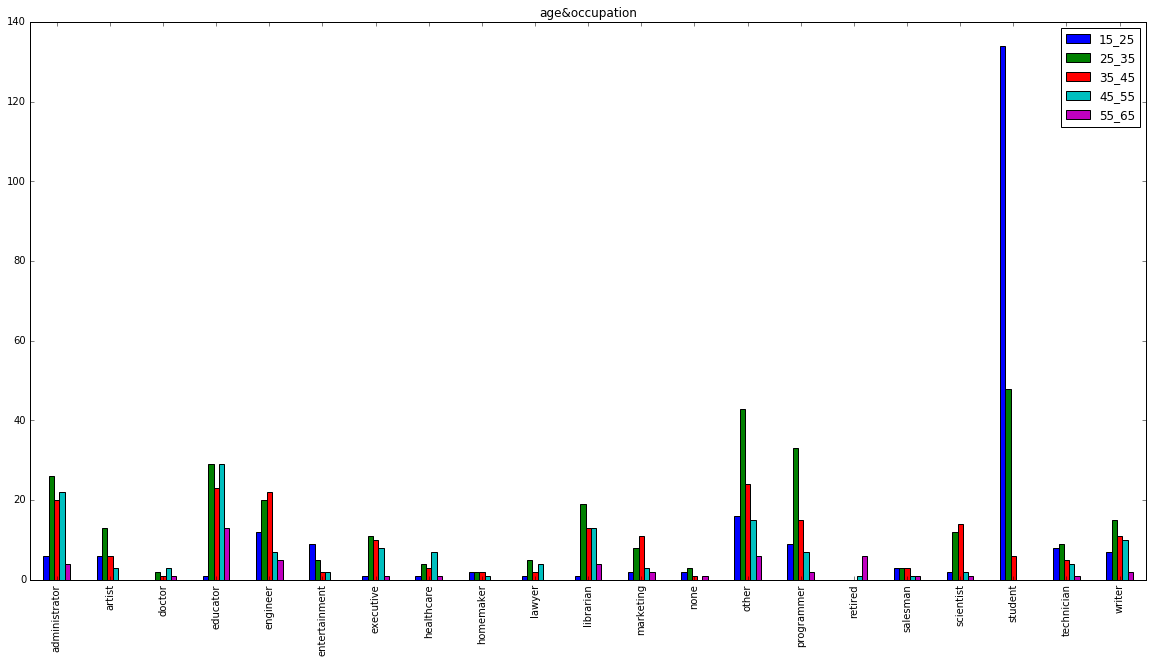

In [17]:
uAndC.ix[:,2:-1].plot(kind='bar',title=u'age&occupation')
fig=plt.gcf()
fig.set_size_inches(20,10)

## 电影数据
** 定义电影年龄为相对于1998年
*  清洗数据
>  定义convert_year函数，将缺失年份设为1990,为后续处理做准备

In [19]:
moviePath="data/ml-100k/u.item"
movie_data = sc.textFile(moviePath)
print movie_data.first()
print "Movies:",movie_data.count()

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
Movies: 1682


In [20]:
def convert_year(x):
        try:
            return int(x[-4:])
        except:
            return 1900

In [21]:
#moive_fields以(id,电影信息)RDD保存信息
moive_fields = movie_data.map(lambda lines:lines.split("|")).map(lambda x:(x[0],x[1:]))
# moive_fields?
# print moive_fields.first()
years=moive_fields.map(lambda fields:(fields[0],fields[1][1]))
# print years.first()
pattern = re.compile(r"\d{2}-\w{3}-\d{4}")
# years=years.filter(lambda x:not pattern.match(x))
errors=moive_fields.filter(lambda x:not pattern.match(x[1][1])).map(lambda x:x[0]).collect()
for error in errors:
    print error,"|".join(moive_fields.lookup(error)[0])
    pattern = re.compile(r"\d{1,2}-\w{3}-\d{4}")
# years=years.filter(lambda x:not pattern.match(x))
print "========================"
errors=moive_fields.filter(lambda x:not pattern.match(x[1][1])).map(lambda x:x[0]).collect()
for error in errors:
    print error,"|".join(moive_fields.lookup(error)[0])
years=years.map(lambda x:(x[0],convert_year(x[1])))
print years.count()

267 unknown||||1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
1373 Good Morning (1971)|4-Feb-1971||http://us.imdb.com/M/title-exact?Good%20Morning%20(1971)|1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
267 unknown||||1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
1682


1
267 unknown||||1|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0
1681


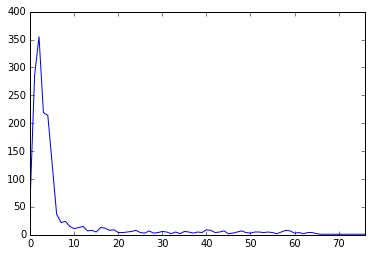

In [22]:
from pandas import Series
years_error=years.filter(lambda x: x[1]==1900).collect()
print len(years_error)
for year in years_error:
    print year[0],"|".join(moive_fields.lookup(year[0])[0])
years_filtered = years.filter(lambda x:x[1]!=1900).map(lambda x:x[1])
print years_filtered.count()
movie_ages = years_filtered.map(lambda yr:1998-yr).countByValue()
values = movie_ages.values()
# movie_ages = sorted(movie_ages.items(),cmp=lambda x,y:1 if x[0]>y[0] else (0 if x[1]==y[1] else -1),reverse=False)
maSeries = Series(movie_ages.values(),index=movie_ages.keys())
# maSeries.sum()
maSeries.plot()

## 评级数据

In [23]:
ratingPath = "data/ml-100k/u.data"
rating_data = sc.textFile(ratingPath)
print rating_data.first()
print "Ratings:",rating_data.count()
print rating_data
def myInt(x):
    try:
        return int(x)
    except:
        return np.nan
rating_data = rating_data.map(lambda x:x.split("\t")).map(lambda x:(myInt(x[0]),myInt(x[1]),myInt(x[2]),myInt(x[3])))

196	242	3	881250949
Ratings: 100000
data/ml-100k/u.data MapPartitionsRDD[139] at textFile at NativeMethodAccessorImpl.java:0


+-------+--------+-------+---------+
|user_id|movie_id|ratings|timestamp|
+-------+--------+-------+---------+
|    196|     242|      3|881250949|
|    186|     302|      3|891717742|
|     22|     377|      1|878887116|
|    244|      51|      2|880606923|
|    166|     346|      1|886397596|
+-------+--------+-------+---------+

+-------+------------------+
|summary|           ratings|
+-------+------------------+
|  count|            100000|
|   mean|           3.52986|
| stddev|1.1256735991443179|
|    min|                 1|
|    max|                 5|
+-------+------------------+



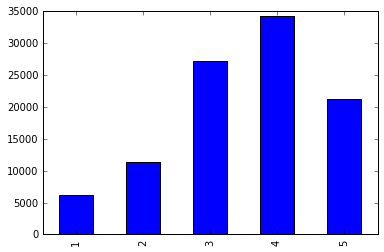

In [24]:
ratingDf=spark.createDataFrame(rating_data,("user_id","movie_id","ratings","timestamp"))
ratingDf.limit(5).show()
# ratingDf.printSchema()
ratingDf.describe('ratings').show()
raPDf=ratingDf.groupBy('ratings').count().sort('ratings').toPandas().sort_index(0)
raPDf.index=list(raPDf.ix[:,0])
raPDf['count'].plot(kind='bar')

In [25]:
# gdf.show()
grDf=ratingDf.join(gdf,gdf.id==ratingDf.user_id)\
.select('newage','occupation','ratings').groupBy('newage','ratings').count().sort(asc('ratings'))
grDf.registerTempTable("ratingtable")
spark.sql("show tables").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
| default|       test|      false|
| default|      test1|      false|
|        |    newuser|       true|
|        |ratingtable|       true|
|        |       user|       true|
+--------+-----------+-----------+



In [26]:
grDf0=spark.sql("select ratings as ratings0,count as a from ratingtable where newage=0")
grDf1=spark.sql("select ratings as ratings1,count as b from ratingtable where newage=1")
grDf2=spark.sql("select ratings as ratings2,count as c from ratingtable where newage=2")
grDf3=spark.sql("select ratings as ratings3,count as d from ratingtable where newage=3")
grDf4=spark.sql("select ratings as ratings4,count as e from ratingtable where newage=4")
grDf5=spark.sql("select ratings as ratings5,count as f from ratingtable where newage=5")
grDf6=spark.sql("select ratings as ratings6,count as g from ratingtable where newage=6")
st=StructType([StructField('ratings',StringType(),True)])
# rdd=sc.parallelize([1,2,3,4,5]).map(lambda x:str(x))
pdf=DataFrame([1,2,3,4,5],columns=["ratings"])
grDf=spark.createDataFrame(pdf,st)
# grDf.show()
grDf=grDf.join(grDf0,grDf0.ratings0==grDf.ratings).select('ratings','a')
grDf=grDf.join(grDf1,grDf1.ratings1==grDf.ratings).select('ratings','a','b')
grDf=grDf.join(grDf2,grDf2.ratings2==grDf.ratings).select('ratings','a','b','c')
grDf=grDf.join(grDf3,grDf3.ratings3==grDf.ratings).select('ratings','a','b','c','d')
grDf=grDf.join(grDf4,grDf4.ratings4==grDf.ratings).select('ratings','a','b','c','d','e')
grDf=grDf.join(grDf5,grDf5.ratings5==grDf.ratings).select('ratings','a','b','c','d','e','f')
grDf=grDf.join(grDf6,grDf6.ratings6==grDf.ratings).select('ratings','a','b','c','d','e','f','g')
grDf=grDf.sort('ratings').toPandas()
grDf

,ratings,a,b,c,d,e,f,g
0,1,101,2008,2398,818,606,152,27
1,2,95,3100,4176,2194,1203,524,78
2,3,198,6812,9680,5536,3466,1271,182
3,4,263,8350,12098,6727,4585,1862,289
4,5,205,5419,7092,4316,2920,1114,135


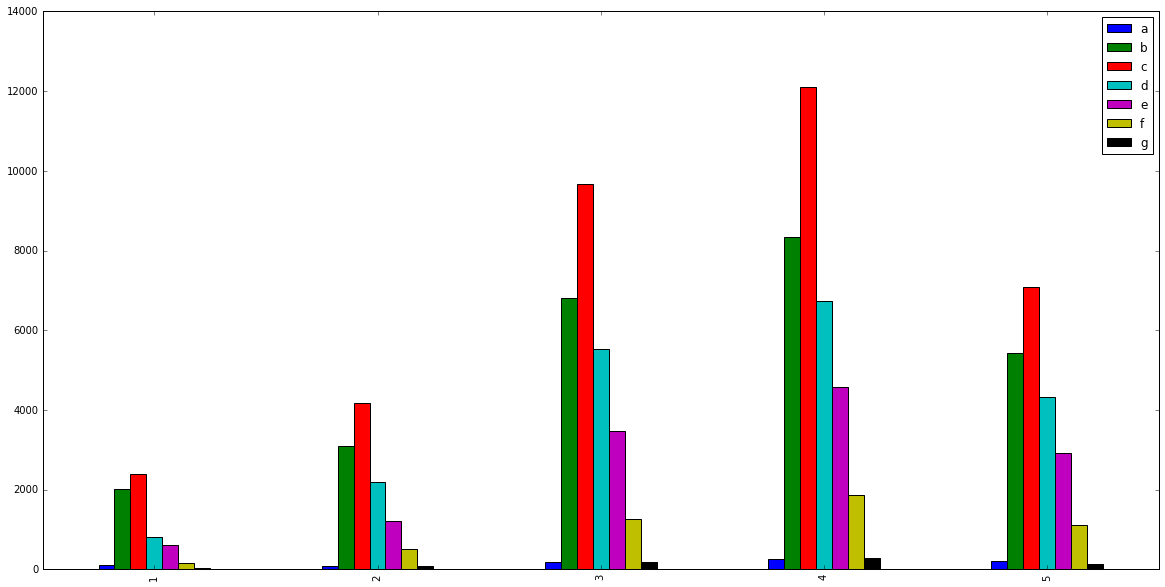

In [27]:
grDf.index=list(grDf['ratings'])
grDf.ix[:,1:].plot(kind='bar')
fig=plt.gcf()
fig.set_size_inches(20,10)
# grDf.dtypes

## 用户推荐
Alternating Least Squares (ALS) matrix factorization.  
$A=XY^{T}$  
$A_{i}Y(Y^{T}Y)^{-1}=X_i$  
$|A_{i}Y(Y^{T}Y)^{-1}-X_i|$ 

In [28]:
ratingDf=ratingDf.select(ratingDf.user_id.alias('user'),ratingDf.movie_id.alias('item'),ratingDf.ratings.alias('rating'))
ratingDf.show()

+----+----+------+
|user|item|rating|
+----+----+------+
| 196| 242|     3|
| 186| 302|     3|
|  22| 377|     1|
| 244|  51|     2|
| 166| 346|     1|
| 298| 474|     4|
| 115| 265|     2|
| 253| 465|     5|
| 305| 451|     3|
|   6|  86|     3|
|  62| 257|     2|
| 286|1014|     5|
| 200| 222|     5|
| 210|  40|     3|
| 224|  29|     3|
| 303| 785|     3|
| 122| 387|     5|
| 194| 274|     2|
| 291|1042|     4|
| 234|1184|     2|
+----+----+------+
only showing top 20 rows



In [29]:
traingDf,cvDf,testDf=ratingDf.randomSplit([6.0,2.0,2.0],24)
cvDf.limit(5).show()

+----+----+------+
|user|item|rating|
+----+----+------+
|   1|   2|     3|
|   1|   5|     3|
|   1|   9|     5|
|   1|  10|     3|
|   1|  21|     1|
+----+----+------+



In [30]:
from pyspark.ml.recommendation import ALS
als =ALS(rank=10,maxIter=5,seed=0)
model = als.fit(traingDf)

In [39]:
model.rank
model.userFactors.limit(5).show()
predictions=model.transform(testDf).filter("user==580").sort(desc('prediction')).limit(10)
predictions.show()
ratingDf.filter("user == 580").sort(desc('rating')).show()

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.71703637, 0.71...|
| 20|[-0.7581753, 0.06...|
| 30|[0.9975454, 0.904...|
| 40|[0.1166557, 0.306...|
| 50|[-0.03754542, 1.6...|
+---+--------------------+

+----+----+------+----------+
|user|item|rating|prediction|
+----+----+------+----------+
| 580|1028|     3|     3.869|
| 580|1014|     3|  3.862942|
| 580| 294|     4| 3.6850061|
| 580| 289|     5|  2.932541|
| 580| 258|     5|  2.768921|
| 580| 286|     4|  2.691989|
| 580| 343|     5| 2.6503823|
| 580| 125|     3|  2.623606|
| 580| 281|     2| 2.5606139|
| 580| 455|     4|  2.472786|
+----+----+------+----------+

+----+----+------+
|user|item|rating|
+----+----+------+
| 580| 252|     5|
| 580| 250|     5|
| 580| 289|     5|
| 580| 257|     5|
| 580| 271|     5|
| 580| 249|     5|
| 580|  50|     5|
| 580| 282|     5|
| 580| 258|     5|
| 580| 288|     5|
| 580| 343|     5|
| 580|   3|     5|
| 580| 181|     5|
| 580| 358|     4|
| 580| 455| 

In [33]:
predictions.select((predictions.rating-predictions.prediction).alias('distince')).limit(10).show()
# als.save("ml/als")
# model.save("ml/als_model")
!hadoop fs -ls /user/yanbin/ml/als
!hadoop fs -ls /user/yanbin/ml/als_model

+-----------+
|   distince|
+-----------+
|  1.5961869|
|-0.47418427|
|-0.45788693|
|  0.4806893|
|   2.018487|
|-0.71518016|
|-0.18460822|
| 0.24131107|
|  0.1405325|
|-0.65575933|
+-----------+

Found 1 items
drwxr-xr-x   - yanbin supergroup          0 2017-05-19 22:06 /user/yanbin/ml/als/metadata
Found 3 items
drwxr-xr-x   - yanbin supergroup          0 2017-05-19 22:06 /user/yanbin/ml/als_model/itemFactors
drwxr-xr-x   - yanbin supergroup          0 2017-05-19 22:06 /user/yanbin/ml/als_model/metadata
drwxr-xr-x   - yanbin supergroup          0 2017-05-19 22:06 /user/yanbin/ml/als_model/userFactors


In [ ]:
from pyspark.ml.recommendation import ALSModel 
model2=ALSModel.load("ml/als_model")
predictions2=model.transform(testDf).limit(10)
predictions2.select((predictions2.rating-predictions2.prediction).alias('distince')).limit(10).show()

In [409]:
sc.stop()